# Community learning
Unsupervised learning on song lyrics data acquired through [Genius API (link)](https://docs.genius.com/) aiming to categorize songs into genre or some kinds of semantic based on lyrics.

* There are $6$ main steps involved
    1. [DATA ACQUISITION (jump to section)](#step1)
    1. [DATA CLEANING (jump to section)](#step2)
    1. [TEXT VECTORIZATION (jump to section)](#step3)
        1. The best model we have employes NLP sentence-level embedding
    1. [UNSUPERVISED MODEL TRAINING (jump to section)](#step4)
        1. `KMeans` is used
    1. [CLUSTER VISUALIZATION (jump to section)](#step5)
        1. 3D visualization using `UMAP` as dimensional reducer and the scatter plot is colored based on its tag from the previous step (KMeans clustering)
    1. [SEGMENT ANALYSIS (jump to section)](#step6)

In [1]:
# importing main modules 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import re

***
## DATA ACQUISITION <a name="step1"></a>
First, we obtained a list of songs from https://goldstandardsonglist.com/Pages_Sort_2a/Sort_2a.htm

Next, we use the song names to retrieve lyrics from [genius.com](https://genius.com/) through its API (registration is required)

In [5]:
# getting list of songs along with its genre
from bs4 import BeautifulSoup as sp
import requests

r = requests.get('https://goldstandardsonglist.com/Pages_Sort_2a/Sort_2a.htm')
soup = sp(r.text, 'html.parser')

title = [x.text.replace('\n', ' ').strip() for x in soup.find_all(class_='table1column2')]
genre = [x.text.replace('\n', ' ').strip() for x in soup.find_all(class_='table1column3')]
pd.DataFrame({'title':title, 'genre':genre}).to_csv(r'data/song_titles.csv')

In [73]:
# retrieving lyrics via genius API
# took 3 hours to retrieve lyrics, so I have commented out this part to not accidentrly run it

# uncomment this cell to run the lyrics retrieval code
'''
import lyricsgenius
CLIENT_KEY = '' # need to create an account with genius to get this key
assert len(CLIENT_KEY) > 0 # client key is needed
genius = lyricsgenius.Genius(CLIENT_KEY)

title_df = pd.read_csv(r'data/song_titles.csv', index_col=0, header='infer')
Lyrics = [None]*len(title_df)
for i in range(len(title_df)):
    # using try except to take care of those songs not avilable in the genius database
    try: 
        x = title_df.title.iloc[i]
        ly = genius.search_song(x).lyrics
        Lyrics[i] = ly
    except:
        None
title_df.append({'lyrics':Lyrics}, ignore_index=True).to_csv(r'data/song_lyrics.csv')
'''

"\nimport lyricsgenius\nCLIENT_KEY = '' # need to create an account with genius to get this key\nassert len(CLIENT_KEY) > 0 # client key is needed\ngenius = lyricsgenius.Genius(CLIENT_KEY)\n\ntitle_df = pd.read_csv(r'data/song_titles.csv', index_col=0, header='infer')\nLyrics = [None]*len(title_df)\nfor i in range(len(title_df)):\n    # using try except to take care of those songs not avilable in the genius database\n    try: \n        x = title_df.title.iloc[i]\n        ly = genius.search_song(x).lyrics\n        Lyrics[i] = ly\n    except:\n        None\ntitle_df.append({'lyrics':Lyrics}, ignore_index=True).to_csv(r'data/song_lyrics.csv')\n"

In [74]:
# songs lyrics has been downloaded using the code in previous cell, so it can simply be imported here
song = pd.read_csv(r'data/song_lyrics.csv', index_col=0, header='infer')
song = song.dropna()
song.reset_index(drop=True, inplace=True)
song


,title,genre,lyrics
0,Abilene,Country/Bluegrass,Abilene Abilene prettiest town I've ever seen\...
1,Above And Beyond (The Call Of Love),Country/Bluegrass,Well I'll give you love that's above and beyon...
2,AC/DC Current,Jazz,"Y'all know me, still the same Eevee\nThe old 1..."
3,Acadian Driftwood,Folk/Roots,The war was over\nAnd the spirit was broken\nT...
4,Ac-Cent-Tchu-Ate The Positive,Swing,"Gather 'round me, everybody\nGather 'round me,..."
...,...,...,...
4754,Zeebob,Jazz,Part One Chapter 10\nTo Kill a Mockingbird\n\n...
4755,Zig Zag Wanderer,Rock/Pop,"Zig zag\n\nZig zag wanderer, zig zag wanderer\..."
4756,Ziggy Stardust,Rock/Pop,Ground Control to Major Tom\nGround Control to...
4757,Zip-A-Dee-Doo-Dah,Musical/Film,"Zip-a-dee-doo-dah\nZip-a-dee-yae\nMy, my, my, ..."


***
## DATA EXPLORATION AND CLEANING <a name="step2"></a>
Filtering out songs with unrelated information

In [3]:
# Upon inspection, some songs contain unrelavant information, 
# i.e. something else that is not lyrics, which might have been 
# caused by our retirval code, API bugs or others, and these 
# songs need to be filtered out before analysis

# first, make all characteres lowercase and remove punctuations
def remove_punct(text, chop_it=False):
    newtext = text.lower()
    newtext = newtext.replace('\n', ' ')
    newtext = re.sub(r'[^\w\s]',' ',newtext)
    newtext = re.sub(r'_',' ', newtext)
    newtext = newtext.replace('  ', ' ')
    return newtext.split() if chop_it else newtext

df = song.copy()
r = []
for row in df.lyrics:
    r.append(remove_punct(row))

Text(0.5, 0, 'number of characters')

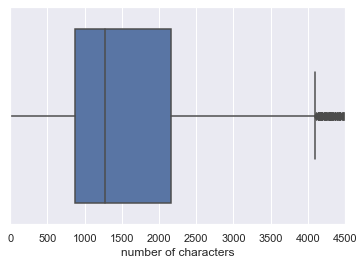

In [4]:
# from boxplot, some samples are deemed "outliers"
# we will simply remove them
r_len = [*map(len, r)]
ax = sns.boxplot(x=r_len)
ax.set_xlim([0, 4500])
ax.set_xlabel('number of characters')

In [5]:
# setting the upper bound based on boxplot 
from scipy.stats import iqr
upper = np.quantile(r_len, q=0.75) + 1.5*iqr(r_len) # getting the cutoff values
upper

4102.75

In [6]:
# an example of upper song filtered out by setting upper bound 

# data like this needs to be removed
# it contains unrelavant information 
# Bug in the API system ??
df.lyrics[df[r_len == np.max(r_len)].index[0]]

'Wage Labour and Capital\nKARL MARX\n\xa0 \xa0 \xa0 \xa0 Shortly after adumbrating the materialist conception of history in the 1844 manuscripts and formulating it comprehensively in Part I of The German Ideology, Marx turned to the economic studies that were going to preoccupy him in the ensuing years. This did not signify any change of interests or outlook but was the logical outgrowth of the position taken in his earlier writings. If the thesis on "alienated labor" was to be made scientifically cogent and if the expectation of coming proletarian revolution was to be based upon it, he needed to show the capital-labor relationship, which he took to be the core of the bourgeois socio-economic system, to be dialectically self-destructive, i.e. , transitory by virtue of its inner dynamics of development. The first work in which he attempted this analysis was Wage Labour and Capital.\n\xa0 \xa0 \xa0 \xa0 Having first presented it in lectures to a German workers\' society in Brussels in De

In [6]:
# as for lower bound, we use trial and error method
# By trial and error, 200 gives a good filter for lower bound
i = 200
while True:
    if any(np.array(r_len) == i):
        break
    i = i+1
lower = np.float64(i) # for comparison purpose in the filter 
df.lyrics[df[np.array(r_len) == i].index[0]]

'Down by the Old Mill Stream\nWhere I first met you\nWith your eyes of blue\nDressed in gingham too\nIt was there I knew\nThat you loved me true\nYou were sixteen, my village queen\nDown by the old mill stream!'

In [8]:
# an example of those samples below lower bound
# as can be seen here, it doesn't contain lyrics at all
df.lyrics[df[r_len == np.min(r_len)].index[0]]

'/'

In [7]:
# removing those songs with too long or short of lyrics 
reduced_df = df.iloc[(r_len >= lower) & (r_len <= upper)].reset_index(drop=True)
reduced_df

,title,genre,lyrics
0,Abilene,Country/Bluegrass,Abilene Abilene prettiest town I've ever seen\...
1,Above And Beyond (The Call Of Love),Country/Bluegrass,Well I'll give you love that's above and beyon...
2,AC/DC Current,Jazz,"Y'all know me, still the same Eevee\nThe old 1..."
3,Acadian Driftwood,Folk/Roots,The war was over\nAnd the spirit was broken\nT...
4,Ac-Cent-Tchu-Ate The Positive,Swing,"Gather 'round me, everybody\nGather 'round me,..."
...,...,...,...
4407,You've Really Got A Hold On Me,R & B/Soul,I don't like you\nBut I love you\nSeems that I...
4408,Zig Zag Wanderer,Rock/Pop,"Zig zag\n\nZig zag wanderer, zig zag wanderer\..."
4409,Ziggy Stardust,Rock/Pop,Ground Control to Major Tom\nGround Control to...
4410,Zip-A-Dee-Doo-Dah,Musical/Film,"Zip-a-dee-doo-dah\nZip-a-dee-yae\nMy, my, my, ..."


***
## TEXT VECTORIZATION <a name="step3"></a>
Google sentence encoder is employed

Pre-trained model can be obtained from https://tfhub.dev/s?module-type=text-embedding

[Reference: towardsdatascience.com](https://towardsdatascience.com/use-cases-of-googles-universal-sentence-encoder-in-production-dd5aaab4fc15#:%7E:text=The%20Universal%20Sentence%20Encoder%20encodes,and%20other%20natural%20language%20tasks.&text=It%20comes%20with%20two%20variations,Deep%20Averaging%20Network%20(DAN).)

Note:
> In order to run code in this section, pre-trained Google's sentence encoder is required.

> You can obtain this as following:
>> 1. Download the pre-trained Universal Sentence Encoder to local drive (can be reused) (this is a big file: ~800 mb): [https://tfhub.dev/google/universal-sentence-encoder-large/3?tf-hub-format=compressed](https://tfhub.dev/google/universal-sentence-encoder-large/3?tf-hub-format=compressed) (credit: [towardsdatascience.com](https://towardsdatascience.com/use-cases-of-googles-universal-sentence-encoder-in-production-dd5aaab4fc15#:%7E:text=The%20Universal%20Sentence%20Encoder%20encodes,and%20other%20natural%20language%20tasks.&text=It%20comes%20with%20two%20variations,Deep%20Averaging%20Network%20(DAN).))
>> 1. Uncompress `.gz` file to obtain `.tar` file.
>> 1. Expand `.tar` file to obtain items inside (there should be around $4$ items: 2 folders and 2 `.pd` files)
>> Assing path to this directory to `ENCODER_DIRECTORY` in the cell below. 

>> For example, I set `ENCODER_DIRECTORY = r'E:\Download\universal-sentence-encoder'`, which means the 4 files are inside `universal-sentence-encoder` folder

In [ ]:
import sys
# wherever you store the downloaded data
ENCODER_DIRECTORY = r''
assert len(ENCODER_DIRECTORY) > 0 # encoder directory needed. 
                                  # See reference for more information.
                                  # See 
sys.path.insert(0, ENCODER_DIRECTORY) 

In [ ]:
# initializing the sentence embedder
import tensorflow as tf
import tensorflow_hub as hub
def embed_useT(module):
    with tf.Graph().as_default():
        sentences = tf.compat.v1.placeholder(tf.string)
        embed = hub.Module(module)
        embeddings = embed(sentences)
        session = tf.compat.v1.train.MonitoredSession()
    return lambda x: session.run(embeddings, {sentences: x})

embed_fn = embed_useT(sys.path[0])

In [12]:
# testing that the sentence encoder takes care of punctuations
messages = [
    "Women there don't treat you mean in Abilene my Abilene",
    "(Women there don't treat you mean) in Abilene my Abilene",
    '-we are sorry for the inconvenience-'
]
encoding_matrix = embed_fn(messages)
np.corrcoef(encoding_matrix)
# can see that the 1st and 2nd sentence are perfectly correlated.
# This shows that the encoder takes care of punctuations, so we
# can simply feed "dirty" sentences to the encoder

array([[1.        , 1.        , 0.06336622],
       [1.        , 1.        , 0.06336622],
       [0.06336622, 0.06336622, 1.        ]])

In [13]:
# assuming that lines are separated via '\n'
lyrics = reduced_df.lyrics.apply(lambda x: x.split('\n'))
lyrics

0       [Abilene Abilene prettiest town I've ever seen...
1       [Well I'll give you love that's above and beyo...
2       [Y'all know me, still the same Eevee, The old ...
3       [The war was over, And the spirit was broken, ...
4       [Gather 'round me, everybody, Gather 'round me...
                              ...                        
4407    [I don't like you, But I love you, Seems that ...
4408    [Zig zag, , Zig zag wanderer, zig zag wanderer...
4409    [Ground Control to Major Tom, Ground Control t...
4410    [Zip-a-dee-doo-dah, Zip-a-dee-yae, My, my, my,...
4411    [Brewton Alabama at The Colonial Inn, Hot day ...
Name: lyrics, Length: 4412, dtype: object

In [14]:
# a dictionary of word vectors, so that it can be 
# used for analysis
dict512 = {}
for i in range(len(reduced_df)):
    dict512[i] = embed_fn(lyrics[i]).sum(axis=0)
    # verifying that this currrent lyrics has vectorized properly
    if len(dict512[i]) != 512:
        assert False

In [15]:
emb512 = pd.DataFrame.from_dict(dict512, 'index')
emb512

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,-0.417694,-0.273301,-0.497077,0.279281,-0.134195,0.280757,-0.055674,0.056154,-0.306759,-0.087069,...,0.004343,0.031972,-0.541976,-0.080049,0.393078,-0.327780,-0.255760,-0.214880,-0.696624,0.119638
1,0.015245,-0.084665,-0.224842,-0.126173,0.145863,-0.061164,0.140698,0.376807,-0.750624,0.289407,...,0.268821,-0.061173,0.496768,-0.107356,0.371449,-0.195768,-0.054972,0.196802,-0.054776,-0.138081
2,0.331611,1.485453,1.152285,-0.331923,-1.566551,1.580761,1.329524,1.457713,-6.406297,1.410015,...,-0.446685,0.776718,-0.593929,-3.392457,0.224442,-0.603661,-0.607495,1.290313,-0.729140,-0.472279
3,0.159585,-1.529899,-1.758890,0.398868,-1.529813,1.512568,-1.126790,-0.602566,-8.825212,1.046128,...,0.227197,1.649740,-0.524690,-4.846576,-0.308326,0.674665,-0.374880,4.465254,-3.207039,-0.241662
4,0.182983,0.892556,-0.014835,-0.711480,-0.928076,0.181591,-0.028055,0.702775,-3.740453,0.875185,...,-1.028350,0.378045,1.005818,-1.134331,-0.366799,-0.625369,0.107308,1.411441,-1.432549,-0.457847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4407,0.304744,-1.142246,-0.603432,0.743110,-0.885288,0.478596,-1.000746,0.774807,-6.093728,1.788039,...,1.009688,-0.043094,2.214637,-1.612269,0.640604,0.777373,-0.300986,2.461582,-1.017403,0.111820
4408,0.478233,-0.303699,-0.155158,-0.982245,-0.987329,0.830471,0.135780,0.813865,-3.198085,0.905359,...,-0.395852,0.462762,-0.077660,-2.242867,-0.433433,-0.299582,-0.201025,1.750647,-0.104683,0.453580
4409,0.538835,-0.023149,-0.351055,0.601294,-0.802972,0.202729,-0.189794,1.065207,-3.122552,0.834161,...,-0.344439,-0.708640,0.496340,-1.653402,-0.579765,0.297186,0.459402,1.709704,-0.390108,-0.729302
4410,0.309442,-0.668647,-0.064661,-0.678259,-0.140431,1.337882,-0.042931,0.197784,-3.821627,0.801547,...,0.553386,0.969614,0.627140,-1.718683,0.054458,-0.428395,0.082142,0.601738,-1.293645,0.883978


***
# DETERMING NUMBER OF CLUSTERS
Here we use elbow method

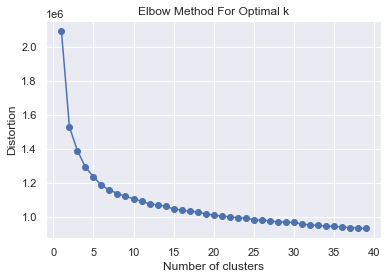

In [58]:
from sklearn.cluster import KMeans

# https://towardsdatascience.com/k-means-clustering-with-scikit-learn-6b47a369a83c
# calculate distortion for a range of number of cluster
X = emb512.values
distortions = []
k_min = 1
k_max = 40
for i in range(k_min, k_max):
    km = KMeans(
        n_clusters=i, init='random',
        max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X)
    distortions.append(km.inertia_)

# plot
plt.figure()
plt.plot(range(k_min, k_max), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method For Optimal k')
plt.show()
# it seems like inflection point located in 5-10 region
# visually inspecting, k=7 seems to be a good choice
# more rigorous calculation can be employed to select the inflection
# but for faster implmenetation, visual based is employed here

***
## UNSUPERVISED MODEL TRAINING <a name="step4"></a>

In [60]:
# kmeans with number of cluster picked via elbow method
from sklearn.cluster import KMeans
cluster_num = 7
model_kmean512 = KMeans(n_clusters=cluster_num, init='random', max_iter=300, tol=1e-04, random_state=0)
model_kmean512.fit(emb512.values)

KMeans(init='random', n_clusters=7, random_state=0)

***
## CLUSTER VISUALIZATION <a name="step5"></a>

In [61]:
# dimensionality reduction for viz
import umap
data512 = emb512.values
# using UMAP as manifold model 
model_viz512 = umap.UMAP(n_neighbors=20, n_components=3)
reduced_emb512 = model_viz512.fit_transform(data512)

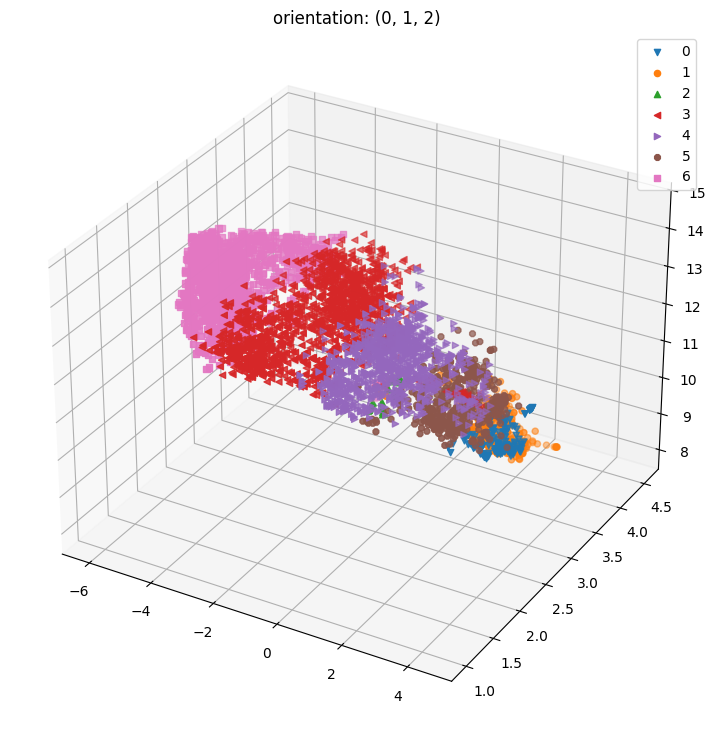

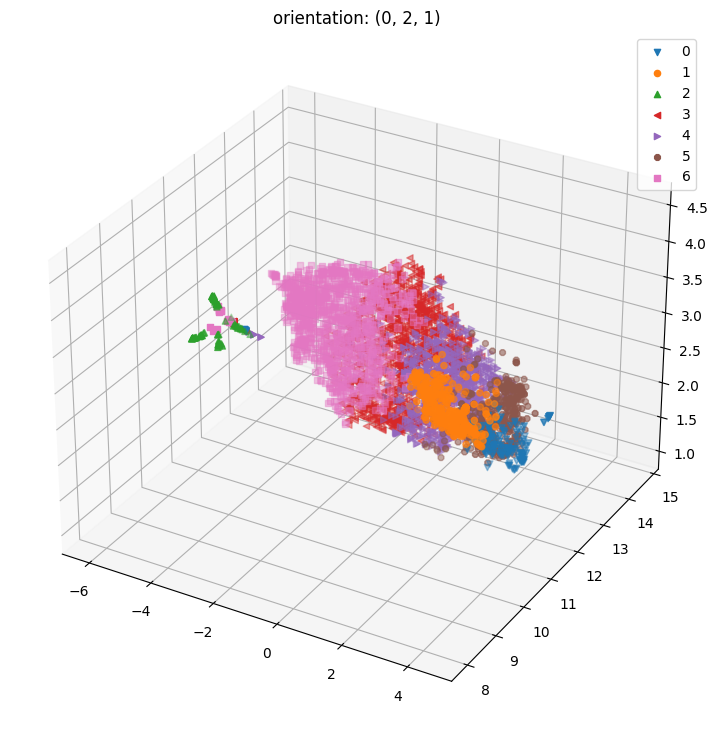

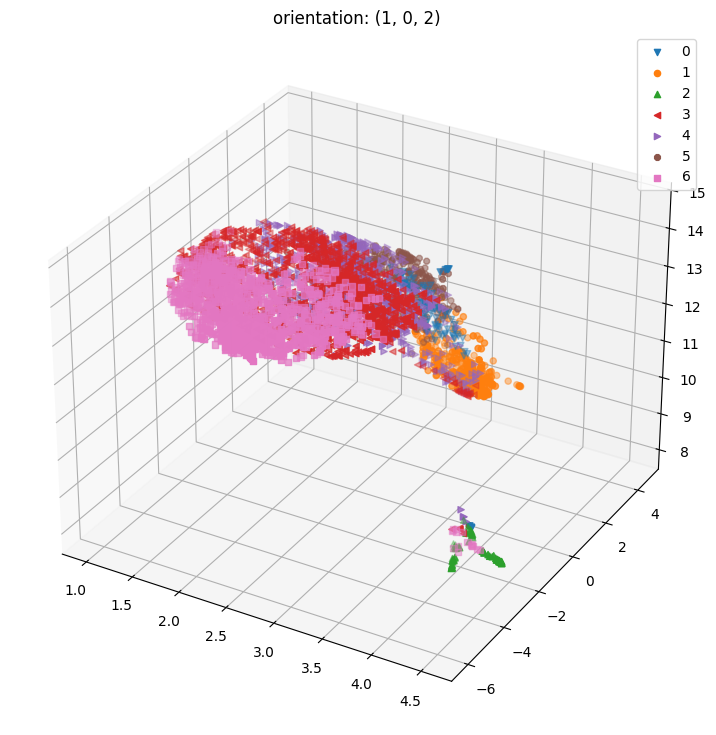

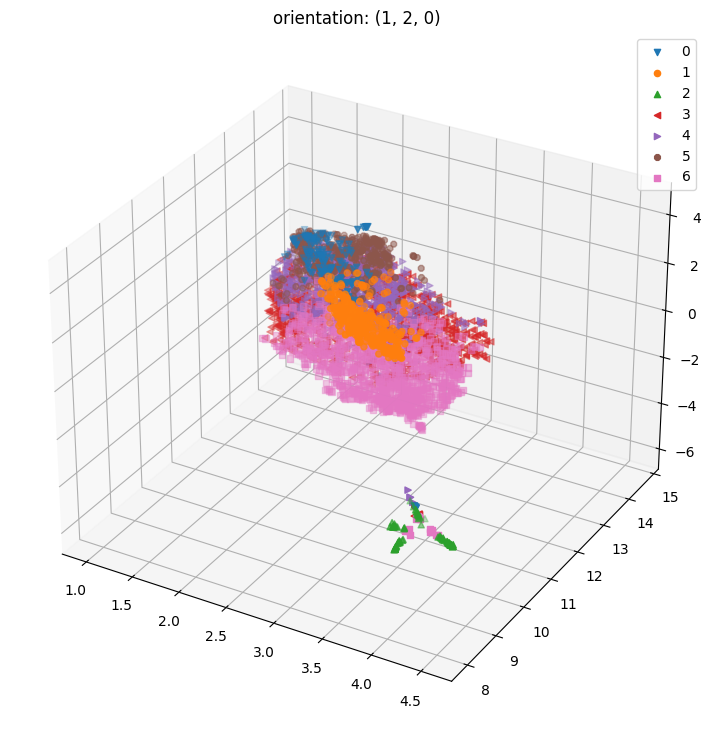

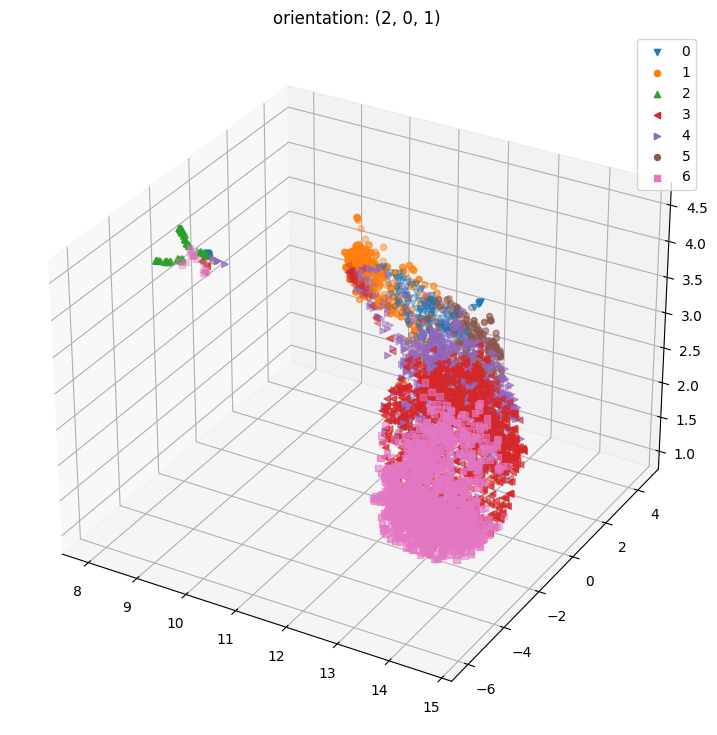

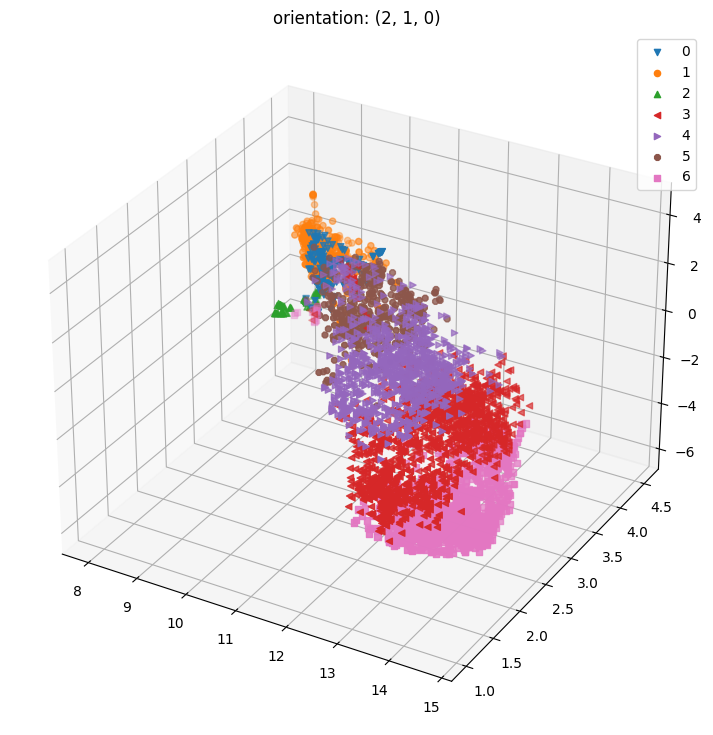

In [72]:
plt.style.use('default')

import itertools
orientation = [*itertools.permutations([0,1,2])]


a = pd.DataFrame({'x':reduced_emb512[:,0], 
                  'y':reduced_emb512[:,1], 
                  'z':reduced_emb512[:,2], 
                  'label':model_kmean512.labels_})

filled_markers = ('v', 'o', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')

for or_i in range(len(orientation)):
    plt.figure(figsize=(12,9))
    ax = plt.axes(projection = '3d')

    for i in range(model_kmean512.n_clusters):
        each = a[a.label==i][list('xyz')].values
        ax.scatter(each[:,orientation[or_i][0]],
                   each[:,orientation[or_i][1]],
                   each[:,orientation[or_i][2]], 
                   marker=filled_markers[i], label=f'{i}')

    ax.legend()
    plt.title(f'orientation: {orientation[or_i]}')
    plt.show()

***
## SEGMENT ANALYSIS <a name="step6"></a>
We will analyze each segments via inspecting the top 10 most frequently appear words for each segment.

In [100]:
import nltk #wordcleaner imports
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pui_s\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [102]:
lower_case_lyrics = reduced_df.lyrics.str.lower() # put everything lowercase

In [103]:
lower_case_lyrics

0       abilene abilene prettiest town i've ever seen\...
1       well i'll give you love that's above and beyon...
2       y'all know me, still the same eevee\nthe old 1...
3       the war was over\nand the spirit was broken\nt...
4       gather 'round me, everybody\ngather 'round me,...
                              ...                        
4407    i don't like you\nbut i love you\nseems that i...
4408    zig zag\n\nzig zag wanderer, zig zag wanderer\...
4409    ground control to major tom\nground control to...
4410    zip-a-dee-doo-dah\nzip-a-dee-yae\nmy, my, my, ...
4411    brewton alabama at the colonial inn\nhot day o...
Name: lyrics, Length: 4412, dtype: object

In [137]:
tokenizer = nltk.RegexpTokenizer(r"\w+") #removes all symbols 
lower_case_lyrics_arr = lower_case_lyrics.apply(tokenizer.tokenize)
lower_case_lyrics_arr

0       [abilene, abilene, prettiest, town, i, ve, eve...
1       [well, i, ll, give, you, love, that, s, above,...
2       [y, all, know, me, still, the, same, eevee, th...
3       [the, war, was, over, and, the, spirit, was, b...
4       [gather, round, me, everybody, gather, round, ...
                              ...                        
4407    [i, don, t, like, you, but, i, love, you, seem...
4408    [zig, zag, zig, zag, wanderer, zig, zag, wande...
4409    [ground, control, to, major, tom, ground, cont...
4410    [zip, a, dee, doo, dah, zip, a, dee, yae, my, ...
4411    [brewton, alabama, at, the, colonial, inn, hot...
Name: lyrics, Length: 4412, dtype: object

In [132]:
stop = (stopwords.words('english')) # removes stopwords from 'english' list
stop.extend(["i've","i'm",'(',')']) #added missing stopwords
stop
# seems like there are only a few stop words. Lets add more.

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [133]:
def get_stop_words():
    '''
    RETURN:
    an array of lower case stop words
    '''
    # https://github.com/stopwords-iso/stopwords-en/blob/master/stopwords-en.txt
    import requests
    r = requests.get('https://raw.githubusercontent.com/stopwords-iso/stopwords-en/master/stopwords-en.txt')
    return r.text.split('\n')

In [134]:
more_stops = get_stop_words()
more_stops

["'ll",
 "'tis",
 "'twas",
 "'ve",
 '10',
 '39',
 'a',
 "a's",
 'able',
 'ableabout',
 'about',
 'above',
 'abroad',
 'abst',
 'accordance',
 'according',
 'accordingly',
 'across',
 'act',
 'actually',
 'ad',
 'added',
 'adj',
 'adopted',
 'ae',
 'af',
 'affected',
 'affecting',
 'affects',
 'after',
 'afterwards',
 'ag',
 'again',
 'against',
 'ago',
 'ah',
 'ahead',
 'ai',
 "ain't",
 'aint',
 'al',
 'all',
 'allow',
 'allows',
 'almost',
 'alone',
 'along',
 'alongside',
 'already',
 'also',
 'although',
 'always',
 'am',
 'amid',
 'amidst',
 'among',
 'amongst',
 'amoungst',
 'amount',
 'an',
 'and',
 'announce',
 'another',
 'any',
 'anybody',
 'anyhow',
 'anymore',
 'anyone',
 'anything',
 'anyway',
 'anyways',
 'anywhere',
 'ao',
 'apart',
 'apparently',
 'appear',
 'appreciate',
 'appropriate',
 'approximately',
 'aq',
 'ar',
 'are',
 'area',
 'areas',
 'aren',
 "aren't",
 'arent',
 'arise',
 'around',
 'arpa',
 'as',
 'aside',
 'ask',
 'asked',
 'asking',
 'asks',
 'associated

In [135]:
stop.extend(more_stops)
stop = set(stop) 
stop

{"doesn't",
 'tt',
 'cc',
 'about',
 'comes',
 'quickly',
 'g',
 'we',
 'mh',
 'rw',
 'goods',
 'whim',
 'despite',
 'theirs',
 'ordered',
 'itself',
 'backs',
 "c'mon",
 'face',
 'consequently',
 'ky',
 'somethan',
 'mightnt',
 'wouldn',
 'arpa',
 'amid',
 'mx',
 'gone',
 'hed',
 'tn',
 'possible',
 'beings',
 'gr',
 'specified',
 'gave',
 'la',
 "would've",
 'afterwards',
 'through',
 'didnt',
 'don',
 'hither',
 'u',
 'seems',
 'vn',
 'lets',
 "weren't",
 'text',
 'opposite',
 'bi',
 "they're",
 'alongside',
 'cy',
 'higher',
 'problems',
 "why's",
 'shouldnt',
 'next',
 'wanted',
 'cf',
 'seem',
 'men',
 'mq',
 'ad',
 'high',
 'sometime',
 'under',
 'over',
 'very',
 'dont',
 'himself',
 'down',
 'now',
 'significant',
 'whereas',
 'om',
 'uz',
 'website',
 'what',
 'looks',
 'back',
 "i've",
 'il',
 'length',
 'around',
 'longest',
 'tip',
 'dare',
 '39',
 'oldest',
 'especially',
 'ask',
 'gu',
 'room',
 'vi',
 'besides',
 'found',
 'changes',
 'nevertheless',
 "he's",
 'sd',
 'e

In [139]:
def remove_stop(arr, stop_words=stop):
    '''
    INPUT:
    arr : [list, or array]
        List of words in the text with all lower cases.
    '''
    new_arr = []
    for word in arr:
        w = word.lower()
        if w in stop:
            continue 
        else:
            new_arr.append(w)
    return new_arr

In [140]:
# removing stop words
lower_case_lyrics_arr_stop_removed = lower_case_lyrics_arr.apply(remove_stop)
lower_case_lyrics_arr_stop_removed

0       [abilene, abilene, prettiest, town, women, tre...
1       [love, love, love, love, love, money, poor, bo...
2       [eevee, 133, key, tryna, level, kanto, streets...
3       [war, spirit, broken, hills, smokin, withdrew,...
4       [gather, gather, preach, feel, sermon, coming,...
                              ...                        
4407    [love, thinking, treat, badly, love, madly, ho...
4408    [zig, zag, zig, zag, wanderer, zig, zag, wande...
4409    [ground, control, major, tom, ground, control,...
4410    [zip, dee, doo, dah, zip, dee, yae, wonderful,...
4411    [brewton, alabama, colonial, inn, hot, day, or...
Name: lyrics, Length: 4412, dtype: object

In [143]:
# grouping all simlar family words together to reduce noise
lem = WordNetLemmatizer() 
lower_case_lyrics_arr_stop_removed_lammatized = lower_case_lyrics_arr_stop_removed.apply(lambda x: [lem.lemmatize(w) for w in x])
lower_case_lyrics_arr_stop_removed_lammatized

0       [abilene, abilene, prettiest, town, woman, tre...
1       [love, love, love, love, love, money, poor, bo...
2       [eevee, 133, key, tryna, level, kanto, street,...
3       [war, spirit, broken, hill, smokin, withdrew, ...
4       [gather, gather, preach, feel, sermon, coming,...
                              ...                        
4407    [love, thinking, treat, badly, love, madly, ho...
4408    [zig, zag, zig, zag, wanderer, zig, zag, wande...
4409    [ground, control, major, tom, ground, control,...
4410    [zip, dee, doo, dah, zip, dee, yae, wonderful,...
4411    [brewton, alabama, colonial, inn, hot, day, or...
Name: lyrics, Length: 4412, dtype: object

In [190]:
def joinList(arr):
    new = []
    for each in arr:
        new.extend(each)
    return new

In [214]:
def countWords(arr):
    w, c = np.unique(arr, return_counts=True)
    df = pd.DataFrame({'word':w, 'count':c}).sort_values('count')
    return df.iloc[-1:-10:-1]

In [202]:
label_df = pd.DataFrame({'lyrics': lower_case_lyrics_arr_stop_removed_lammatized, 
              'label':model_kmean512.labels_}).groupby('label').agg(joinList)
label_df

,lyrics
label,
0,"[loving, wonderful, miracle, rest, assured, fe..."
1,"[eevee, 133, key, tryna, level, kanto, street,..."
2,"[verse, 1, deceneu, sunt, frizeru, din, peru, ..."
3,"[gather, gather, preach, feel, sermon, coming,..."
4,"[lazy, loving, lazy, play, lazy, girlfriend, t..."
5,"[war, spirit, broken, hill, smokin, withdrew, ..."
6,"[abilene, abilene, prettiest, town, woman, tre..."


In [218]:
for row_num, ly in label_df.iterrows():
    print(f'cluster: {row_num}')
    display(countWords(list(ly)))

cluster: 0


,word,count
4982,yeah,808
2610,love,707
265,baby,672
1269,doh,454
1749,funk,364
4787,wanna,321
1576,feel,315
2038,hey,315
4511,time,276


cluster: 1


,word,count
11022,yeah,1526
6644,nigga,1501
1015,bitch,970
3956,fuck,771
8721,shit,706
3246,em,498
10696,wanna,481
5826,love,463
523,as,454


cluster: 2


,word,count
4107,le,364
7525,tu,227
3467,ich,190
7235,te,190
2473,est,182
2177,du,180
5257,pa,160
2346,en,156
4580,mi,140


cluster: 3


,word,count
5951,love,1946
10411,time,1115
11552,yeah,1045
657,baby,980
2634,day,846
6815,night,733
4184,girl,647
4265,gonna,548
4622,heart,548


cluster: 4


,word,count
5788,love,1808
11126,yeah,1636
10082,time,1098
636,baby,1078
2537,day,687
6797,ooh,674
3579,feel,653
4196,gonna,652
6590,night,594


cluster: 5


,word,count
3503,love,1500
366,baby,1159
6737,yeah,1104
6502,wanna,646
6099,time,638
4098,ooh,624
2494,girl,547
2180,feel,543
3409,life,498


cluster: 6


,word,count
4589,love,1351
7876,time,586
2028,day,556
482,baby,479
3632,heart,475
815,blue,464
5207,night,378
4434,life,306
2722,eye,304


### DISCUSSION:
> For cluster $0$, it seems like a kind of music that expressess love to a special someone.

> For cluster $1$, words look like something out of hip-hop musics.

> For cluster $2$, it looks like non-english songs, and it is the smallestcluster of all.

> For cluster $3$, this seems similar to the $0^{th}$ cluster, love expression for special someone, but the difference lies at choice of words. Songs in this cluster seem to use time-related words, i.e., 'day' and 'night', rather than using emotional words like 'feel' and 'wanna' from the other cluster.

> For cluster $4$, it looks like love-expressing songs which has characteristics of both the $0^{th}$ and $3^{rd}$ clusters.

> For cluster $5$, this looks identical to the $4^{th}$ cluster, and they are neightbors clusters based on the 3d plot. 

> For cluster $6$, this seems like heart-broken songs, since the most frequent words are about love and blue, which is usally an expression of sadness, relaying the sadness stammed from love, aka heart borken.